# 08_TopicLDA_Bayes
## Ray Hossain

## Setup

!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info
-- Upgrade gensim in case.
!pip install --upgrade numpy
!pip install -U gensim==4.*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import spacy

from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

In [2]:
data = pd.read_csv("Processed_Data/50_textscored_long.csv")

In [3]:
valid_mask = data['text_clean'].notna()


In [4]:
valid_mask.head()

0    True
1    True
2    True
3    True
4    True
Name: text_clean, dtype: bool

## SpaCy

In [5]:
# Load the German model
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

def improved_filter(tokenized_doc):
    return [t.lemma_ for t in tokenized_doc if
            t.is_alpha and \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.pos_ in ['NOUN', 'VERB', 'ADJ']]

## Topic LDA

In [6]:
NUM_PROCESS = 4

In [7]:
NUM_TOPICS = 10

In [8]:
# We'll need to retokenize everything and rebuild the BOWs. Because we're now
# using the POS tagger, this will take longer. The "w_pos" in the variable 
# names below just means "with part-of-speech".
tokenized_articles_w_pos = list(map(
    improved_filter, 
    nlp.pipe(data.loc[valid_mask, 'text_clean'].astype(str), n_process=NUM_PROCESS)
))

# 3. Create corpus and filter
dictionary_w_pos = corpora.Dictionary(tokenized_articles_w_pos)


### Trimming low & high frequency cells

In [9]:
len(dictionary_w_pos)

60803

The filtering is a bit idiosyncratic. The lower bound is an *absolute* number, and the upper bound is a *percentage*. Here, we're saying filter out words which occur in fewer than N documents and more than M% of the documents.

In [10]:
dictionary_w_pos.filter_extremes(no_below=10, no_above=0.25)

In [11]:
len(dictionary_w_pos)

14281

In [12]:
# Rebuild bag of words.
corpus_bow_w_pos_filtered = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

In [13]:
lda_model = models.ldamodel.LdaModel(
    corpus=corpus_bow_w_pos_filtered,
    id2word=dictionary_w_pos,
    num_topics=NUM_TOPICS,
    passes=10,
    alpha='auto',
    eta='auto',
    random_state=42
)


c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\gensim\models\ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [14]:
lda_model.print_topics()

[(0,
  '0.082*"Bewertung" + 0.049*"September" + 0.041*"Wahl" + 0.036*"deutsch" + 0.029*"Chef" + 0.027*"verlieren" + 0.017*"Geldanlage" + 0.017*"gruen" + 0.016*"neu" + 0.016*"wertpapi"'),
 (1,
  '0.097*"Fussball" + 0.043*"Ticker" + 0.038*"Frau" + 0.029*"Who" + 0.025*"koeln" + 0.019*"warnen" + 0.018*"spielen" + 0.017*"wissen" + 0.014*"stellen" + 0.013*"muenchen"'),
 (2,
  '0.037*"Partei" + 0.035*"Show" + 0.028*"Bericht" + 0.022*"Kind" + 0.022*"Stadt" + 0.021*"schulz" + 0.020*"Auto" + 0.019*"Kandidat" + 0.016*"Russland" + 0.016*"Familie"'),
 (3,
  '0.099*"Politik" + 0.046*"Inland" + 0.041*"Euro" + 0.026*"sterben" + 0.024*"Wahlkampf" + 0.023*"Geld" + 0.023*"Wirtschaft" + 0.021*"drohen" + 0.016*"sendung" + 0.013*"Ergebnis"'),
 (4,
  '0.210*"Sendung" + 0.028*"stehen" + 0.024*"dahoam" + 0.024*"Sport" + 0.020*"Kommentar" + 0.019*"auto" + 0.019*"gutschrift" + 0.017*"Frage" + 0.016*"stark" + 0.015*"Regionalsport"'),
 (5,
  '0.145*"Ausland" + 0.040*"Umfrage" + 0.039*"Erdbeben" + 0.029*"erdbeben" 

In [15]:
print(lda_model.alpha)
print(lda_model.eta)

[0.4880217  0.58327866 0.41811123 0.4871111  0.3257642  0.4638559
 0.4432578  0.34863454 0.35818267 0.39778164]
[0.07892876 0.076275   0.06882113 ... 0.07016492 0.07059152 0.06953669]


Looking at distributions


Function

### Evaluation/Coherence

In [17]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_articles_w_pos, dictionary=dictionary_w_pos, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -15.168992798287372


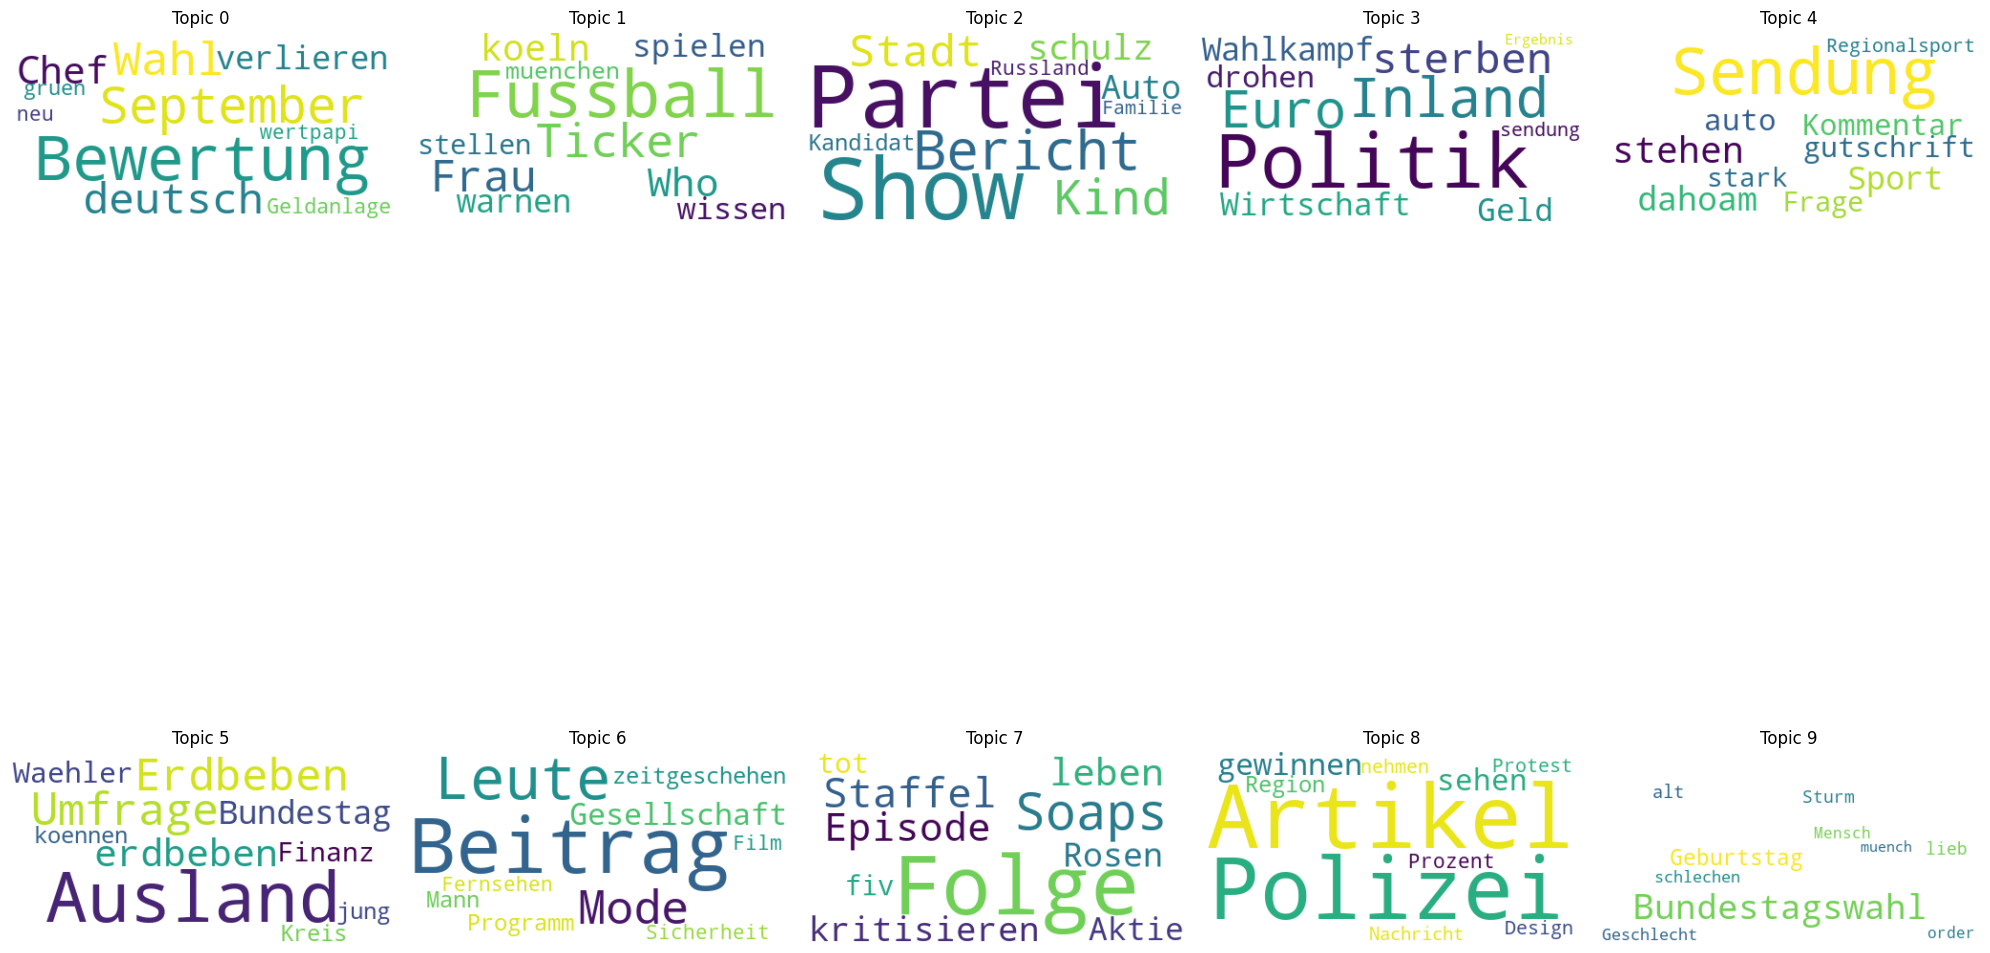

In [18]:
# For a larger visualization
def render_word_cloud(model, rows, cols, max_words):
    word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Increased figure size
    
    for i, ax in enumerate(axes.flatten()):
        if i < model.num_topics:  # Only process valid topic indices
            fig.add_subplot(ax)
            topic_words = dict(model.show_topic(i))
            word_cloud.generate_from_frequencies(topic_words)
            plt.gca().imshow(word_cloud, interpolation='bilinear')
            plt.gca().set_title('Topic {id}'.format(id=i))
            plt.gca().axis('off')
    
    plt.axis('off')
    plt.tight_layout()  # Improves spacing between subplots
    plt.show()

# Visualize all 20 topics
render_word_cloud(lda_model, 2, 5, 10)

### Visualization in English 
 

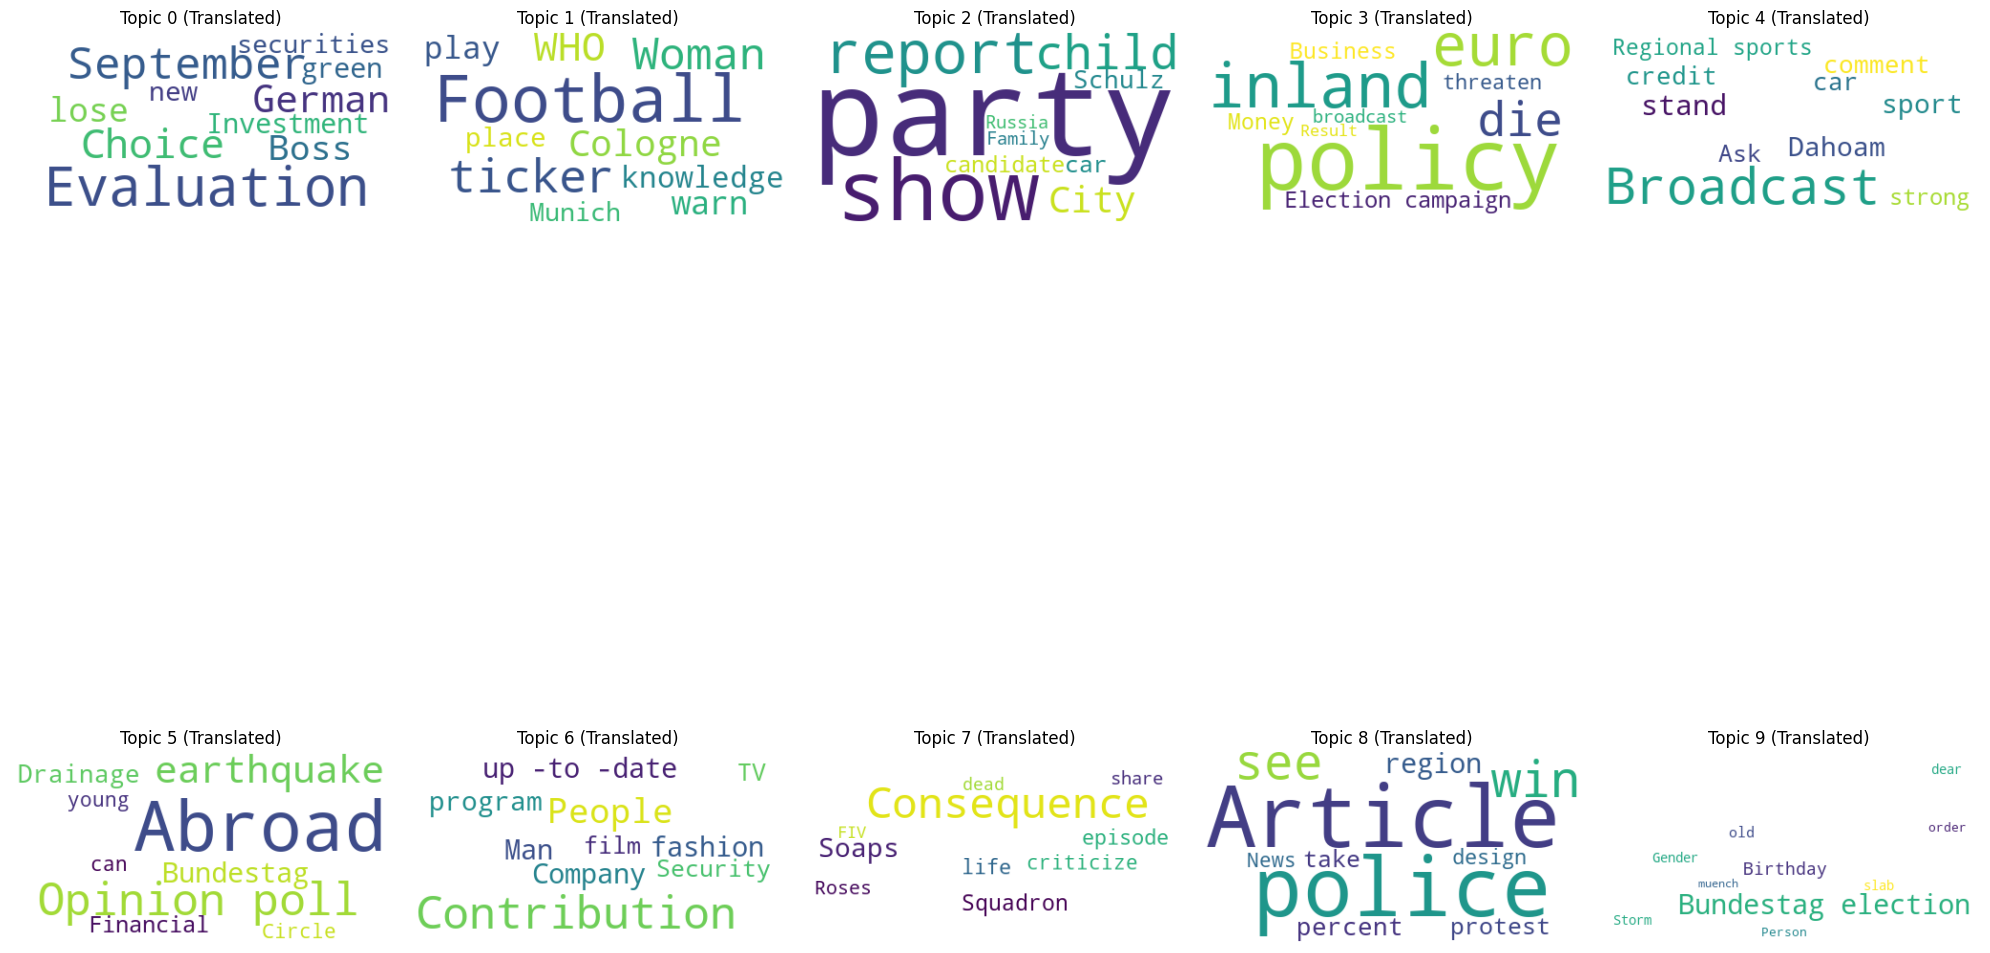

In [19]:
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def render_word_cloud_with_translation(model, rows, cols, max_words):
    translator = GoogleTranslator(source='de', target='en')  # German to English
    word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    
    for i, ax in enumerate(axes.flatten()):
        if i < model.num_topics:
            fig.add_subplot(ax)
            topic_words = dict(model.show_topic(i))
            
            # Translate the words to English
            translated_words = {}
            for word, weight in topic_words.items():
                try:
                    translated = translator.translate(word)
                    translated_words[translated] = weight
                except Exception as e:
                    print(f"Failed to translate '{word}': {e}")
                    translated_words[word] = weight  # Fallback to original
            
            word_cloud.generate_from_frequencies(translated_words)
            plt.gca().imshow(word_cloud, interpolation='bilinear')
            plt.gca().set_title(f'Topic {i} (Translated)')
            plt.gca().axis('off')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize all topics with translation
render_word_cloud_with_translation(lda_model, 2, 5, 10)

This is what 15 Topics looked like: 

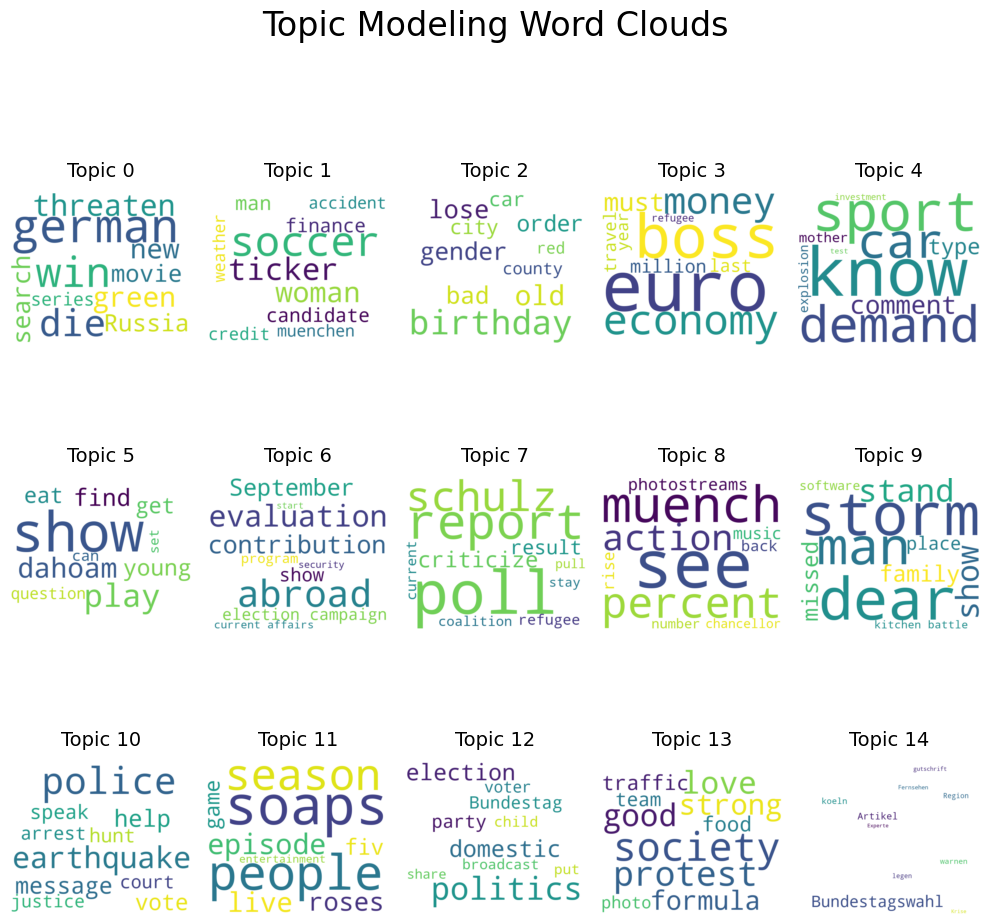

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

def parse_topic_string(topic_str):
    """Parse topic string into word-weight dictionary, handling smart quotes"""
    pattern = r'(\d+\.\d+)\*[“"]([^”"]+)[”"]'
    matches = re.findall(pattern, topic_str)
    return {word: float(weight) for weight, word in matches}

# Updated topic data with mixed German/English terms
topics = [
    (0, '0.088*“german” + 0.068*“win” + 0.054*“die” + 0.047*“threaten” + 0.041*“green” + 0.039*“new” + 0.032*“search” + 0.030*“Russia” + 0.029*“movie” + 0.025*“series”'),
    (1, '0.228*“soccer” + 0.105*“ticker” + 0.088*“woman” + 0.036*“man” + 0.033*“candidate” + 0.033*“finance” + 0.026*“credit” + 0.024*“weather” + 0.024*“muenchen” + 0.024*“accident”'),
    (2, '0.142*“birthday” + 0.090*“old” + 0.074*“lose” + 0.068*“gender” + 0.066*“bad” + 0.058*“order” + 0.047*“city” + 0.046*“car” + 0.030*“county” + 0.027*“red”'),
    (3, '0.122*“euro” + 0.089*“boss” + 0.068*“economy” + 0.054*“money” + 0.040*“must” + 0.036*“million” + 0.034*“last” + 0.032*“travel” + 0.029*“year” + 0.026*“refugee”'),
    (4, '0.079*“know” + 0.061*“sport” + 0.056*“demand” + 0.052*“car” + 0.052*“comment” + 0.040*“type” + 0.040*“mother” + 0.035*“explosion” + 0.031*“investment” + 0.023*“test”'),
    (5, '0.360*“show” + 0.057*“play” + 0.042*“dahoam” + 0.030*“find” + 0.028*“young” + 0.026*“get” + 0.026*“eat” + 0.025*“question” + 0.023*“can” + 0.018*“set”'),
    (6, '0.194*“abroad” + 0.141*“evaluation” + 0.099*“contribution” + 0.088*“September” + 0.051*“show” + 0.038*“election campaign” + 0.027*“program” + 0.026*“current affairs” + 0.020*“security” + 0.018*“start”'),
    (7, '0.111*“poll” + 0.069*“report” + 0.049*“schulz” + 0.045*“criticize” + 0.035*“result” + 0.029*“refugee” + 0.028*“current” + 0.026*“coalition” + 0.024*“stay” + 0.023*“pull”'),
    (8, '0.111*“see” + 0.068*“muench” + 0.055*“percent” + 0.044*“action” + 0.042*“photostreams” + 0.041*“music” + 0.039*“rise” + 0.034*“back” + 0.033*“number” + 0.028*“chancellor”'),
    (9, '0.081*“storm” + 0.078*“dear” + 0.060*“man” + 0.042*“stand” + 0.040*“show” + 0.036*“family” + 0.035*“missed” + 0.032*“place” + 0.032*“software” + 0.030*“kitchen battle”'),
    (10, '0.126*“police” + 0.083*“earthquake” + 0.047*“help” + 0.045*“message” + 0.043*“vote” + 0.032*“speak” + 0.031*“hunt” + 0.027*“court” + 0.027*“arrest” + 0.025*“justice”'),
    (11, '0.324*“episode” + 0.081*“soaps” + 0.064*“people” + 0.051*“season” + 0.047*“episode” + 0.044*“live” + 0.038*“roses” + 0.027*“fiv” + 0.025*“game” + 0.024*“entertainment”'),
    (12, '0.189*“politics” + 0.086*“domestic” + 0.083*“election” + 0.049*“party” + 0.043*“Bundestag” + 0.037*“voter” + 0.032*“child” + 0.031*“broadcast” + 0.031*“put” + 0.027*“share”'),
    (13, '0.087*“society” + 0.065*“protest” + 0.053*“love” + 0.052*“good” + 0.045*“strong” + 0.037*“formula” + 0.031*“traffic” + 0.031*“food” + 0.026*“team” + 0.025*“photo”'),
    (14, '0.325*“Bundestagswahl” + 0.067*“Artikel” + 0.056*“koeln” + 0.044*“warnen” + 0.037*“Region” + 0.030*“legen” + 0.025*“Fernsehen” + 0.024*“gutschrift” + 0.019*“Experte” + 0.019*“Krise”')
]

# Set up visualization parameters
rows, cols = 3, 5  # 15 topics in 5x3 grid
max_words = 15

def visualize_topics(topics_data, rows, cols, max_words):
    """Create word clouds for each topic in a grid layout"""
    wordcloud = WordCloud(
        width=600,
        height=500,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        prefer_horizontal=0.9,
        min_font_size=10
    )
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.suptitle('Topic Modeling Word Clouds', fontsize=24, y=1.02)
    
    for idx, (topic_num, topic_str) in enumerate(topics_data):
        ax = axes.flatten()[idx]
        
        # Parse topic string and create word cloud
        word_freq = parse_topic_string(topic_str)
        wordcloud.generate_from_frequencies(word_freq)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {topic_num}', fontsize=14, pad=12)
        ax.axis('off')
    
    # Hide empty subplots
    for j in range(len(topics_data), rows * cols):
        axes.flatten()[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate the visualization
visualize_topics(topics, rows, cols, max_words)

I have decided to keep the 10 topics model:

0: Politics
1: Soccer
2: Demographics
3: Society/Contribution
4: Entertainment
5: Domestic 
6: Elections
7: Entertainment
8: Travel
9: General

In [21]:
topic_mapping = {
    0: 'Economy',
    1: 'Sports',
    2: 'Elections',
    3: 'Politics',
    4: 'Sports',
    5: 'Current Events',
    6: 'Entertainment',
    7: 'Entertainment',
    8: 'Law and Order',
    9: 'General'
}

In [22]:
import numpy as np

In [23]:
# --- Define helper functions ---
def get_dominant_topic(lda_model, bow):
    """Returns the topic ID with the highest probability for a document."""
    topic_dist = lda_model[bow]
    if not topic_dist:  # handle empty documents
        return np.nan  # or -1 if you prefer numeric placeholder
    return max(topic_dist, key=lambda x: x[1])[0]  # returns topic with highest probability

In [24]:
# 5. Initialize topic columns
data['dominant_topic'] = np.nan  # or -1 for numeric placeholder
data['topic_label'] = "Unassigned"

# 6. Assign topics to valid rows only
valid_topics = [get_dominant_topic(lda_model, bow) for bow in corpus_bow_w_pos_filtered]
data.loc[valid_mask, 'dominant_topic'] = valid_topics
data.loc[valid_mask, 'topic_label'] = data.loc[valid_mask, 'dominant_topic'].map(topic_mapping)

In [25]:
# Get the top N words for each topic
def get_topic_terms(topic_id, topn=10):
    if np.isnan(topic_id):  # Handle NaN/NA dominant_topic values
        return []
    return [word for word, prob in lda_model.show_topic(int(topic_id), topn=topn)]

# Create a dictionary of topic terms (including handling for missing topics)
topic_terms = {
    i: [word for word, prob in lda_model.show_topic(i, topn=5)] 
    for i in range(lda_model.num_topics)
}

# Map to DataFrame - handles NaN/NA values via the function
data['topic_terms'] = data['dominant_topic'].apply(get_topic_terms)

In [26]:
# Add dominant topic probability column (aligned with valid documents only)
data['dominant_topic_prob'] = np.nan  # Initialize with NA values
valid_probs = [max(lda_model[bow], key=lambda x: x[1])[1] if bow else np.nan 
             for bow in corpus_bow_w_pos_filtered]
data.loc[valid_mask, 'dominant_topic_prob'] = valid_probs

In [ ]:
#data.head()

,personid,urlid,duration,text_clean,secondvote,vote_left,vote_green,vote_spd,vote_na_other,vote_fdp,...,fmaritalstatus,femployment,tf_idf_mean,tf_idf_entity_weighted,tf_idf_importance_weighted,left_right,dominant_topic,topic_label,topic_terms,dominant_topic_prob
0,1120454,ger-24,117.0,inland volker kauder rechnet verfassungsklage ...,3,0,0,0,0,1,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.000070,0.404758,0.402514,1,5.0,Current Events,"[Ausland, Umfrage, Erdbeben, erdbeben, Bundest...",0.336710
1,1120454,ger-24,21.0,inland volker kauder rechnet verfassungsklage ...,3,0,0,0,0,1,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.000070,0.404758,0.402514,1,5.0,Current Events,"[Ausland, Umfrage, Erdbeben, erdbeben, Bundest...",0.336709
2,1120454,ger-302,62.0,07-01 wer wei denn sowas xxl stream quiz kai p...,3,0,0,0,0,1,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.000101,0.270928,0.270510,1,0.0,Economy,"[Bewertung, September, Wahl, deutsch, Chef, ve...",0.299132
3,1120454,ger-302,32.0,07-01 wer wei denn sowas xxl stream quiz kai p...,3,0,0,0,0,1,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.000101,0.270928,0.270510,1,0.0,Economy,"[Bewertung, September, Wahl, deutsch, Chef, ve...",0.299132
4,1120454,ger-302,10.0,07-01 wer wei denn sowas xxl stream quiz kai p...,3,0,0,0,0,1,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.000101,0.270928,0.270510,1,0.0,Economy,"[Bewertung, September, Wahl, deutsch, Chef, ve...",0.299132


In [ ]:
#data[data['text_clean'].isna()]

,personid,urlid,duration,text_clean,secondvote,vote_left,vote_green,vote_spd,vote_na_other,vote_fdp,...,fmaritalstatus,femployment,tf_idf_mean,tf_idf_entity_weighted,tf_idf_importance_weighted,left_right,dominant_topic,topic_label,topic_terms,dominant_topic_prob
72,1196105,ger-2624,3.0,NaN,5,1,0,0,0,0,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.0,0.0,0.0,-1,NaN,Unassigned,[],NaN
73,1196105,ger-2624,4.0,NaN,5,1,0,0,0,0,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.0,0.0,0.0,-1,NaN,Unassigned,[],NaN
76,1196105,ger-2624,4.0,NaN,5,1,0,0,0,0,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.0,0.0,0.0,-1,NaN,Unassigned,[],NaN
81,1196105,ger-2624,4.0,NaN,5,1,0,0,0,0,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.0,0.0,0.0,-1,NaN,Unassigned,[],NaN
82,1196105,ger-2624,8.0,NaN,5,1,0,0,0,0,...,geschieden,Erwerbst?tigkeit/Berufst?tigkeit,0.0,0.0,0.0,-1,NaN,Unassigned,[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452850,41378722,NaN,NaN,NaN,1,0,0,0,0,0,...,verheiratet,Angeh?rige,0.0,0.0,0.0,1,NaN,Unassigned,[],NaN
452851,41571157,NaN,NaN,NaN,7,0,0,0,1,0,...,ledig,Sonstige Unterst?tzungen (z.B. Baf?G),0.0,0.0,0.0,0,NaN,Unassigned,[],NaN
452852,41791374,NaN,NaN,NaN,7,0,0,0,1,0,...,ledig,Erwerbst?tigkeit/Berufst?tigkeit,0.0,0.0,0.0,0,NaN,Unassigned,[],NaN
452853,41942929,NaN,NaN,NaN,4,0,1,0,0,0,...,ledig,keine Angabe,0.0,0.0,0.0,-1,NaN,Unassigned,[],NaN


In [29]:
data['topic_label'].value_counts()

topic_label
Sports            149470
Entertainment      64645
Economy            54282
Politics           49494
Current Events     37076
Elections          29342
General            27019
Law and Order      22950
Unassigned         18577
Name: count, dtype: int64

In [30]:
data['dominant_topic_prob'].value_counts()

dominant_topic_prob
0.280018    6515
0.271594    4939
0.271594    3253
0.297942    2396
0.280018    2388
            ... 
0.208492       1
0.208492       1
0.208492       1
0.238873       1
0.398128       1
Name: count, Length: 166660, dtype: int64

In [31]:
data.to_csv('Processed_Data/80_TopicLDA_Long.csv', index= False)

## Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     14355
           2       0.26      0.98      0.42     23294
           3       0.00      0.00      0.00     10419
           4       0.00      0.00      0.00      5961
           5       0.00      0.00      0.00     12052
           6       0.00      0.00      0.00     12686
           7       0.26      0.08      0.13     11804

    accuracy                           0.26     90571
   macro avg       0.08      0.15      0.08     90571
weighted avg       0.10      0.26      0.12     90571



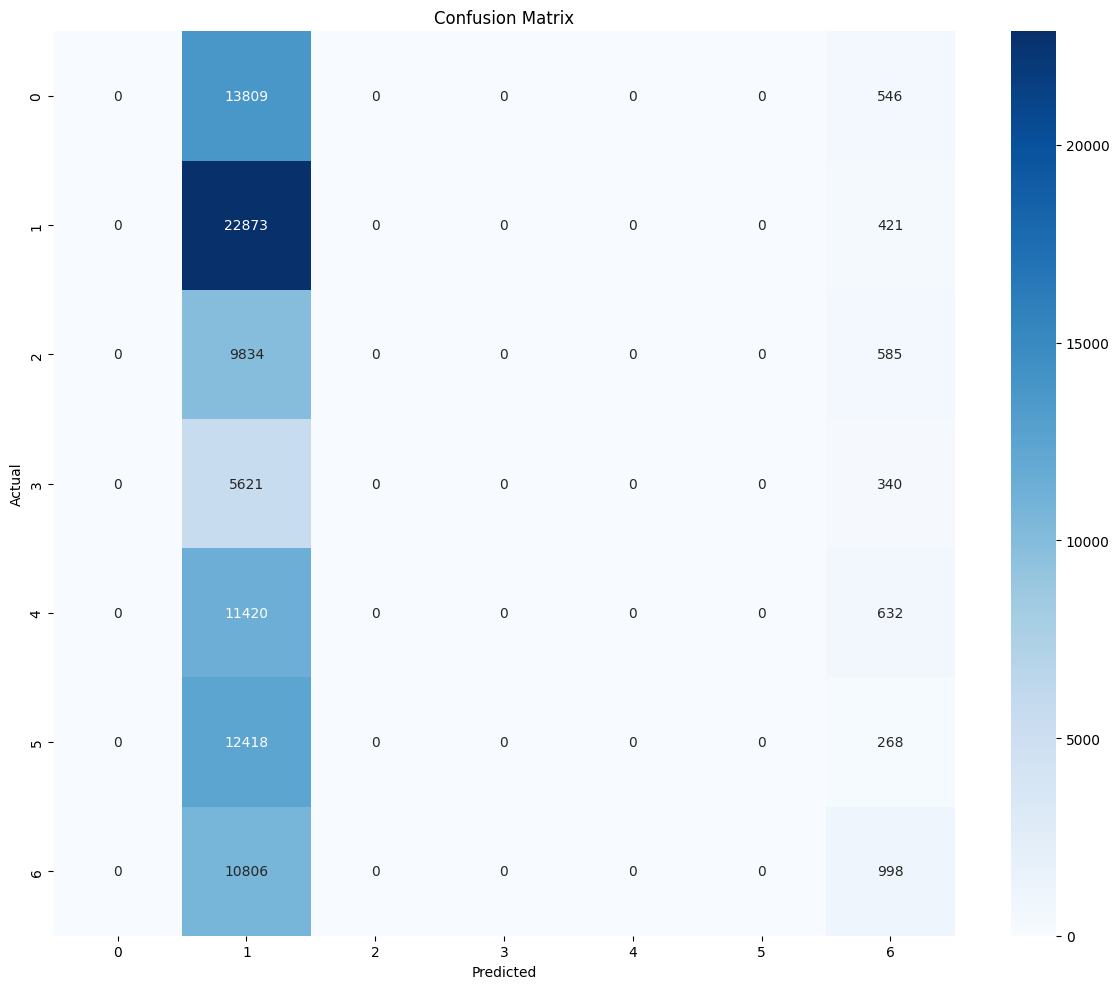


Topic Effects on Voting:
                 Class_1   Class_2   Class_3   Class_4   Class_5   Class_6  \
Current Events  0.107145  0.074164  0.087919  0.048046  0.074374  0.102061   
Economy         0.091525  0.181714  0.103752  0.067080  0.101564  0.118276   
Elections       0.072492  0.058979  0.063858  0.052197  0.058113  0.064862   
Entertainment   0.116008  0.123239  0.123375  0.350662  0.176622  0.115557   
General         0.045553  0.088673  0.049321  0.031192  0.047536  0.060015   
Law and Order   0.052449  0.054268  0.049513  0.043015  0.043056  0.055779   
Politics        0.118742  0.097677  0.121312  0.074459  0.100050  0.143890   
Sports          0.357602  0.303869  0.344216  0.278886  0.346441  0.319916   
Unassigned      0.038484  0.017417  0.056734  0.054461  0.052244  0.019644   

                 Class_7  
Current Events  0.064306  
Economy         0.094416  
Elections       0.084316  
Entertainment   0.118936  
General         0.055583  
Law and Order   0.048383  
Poli

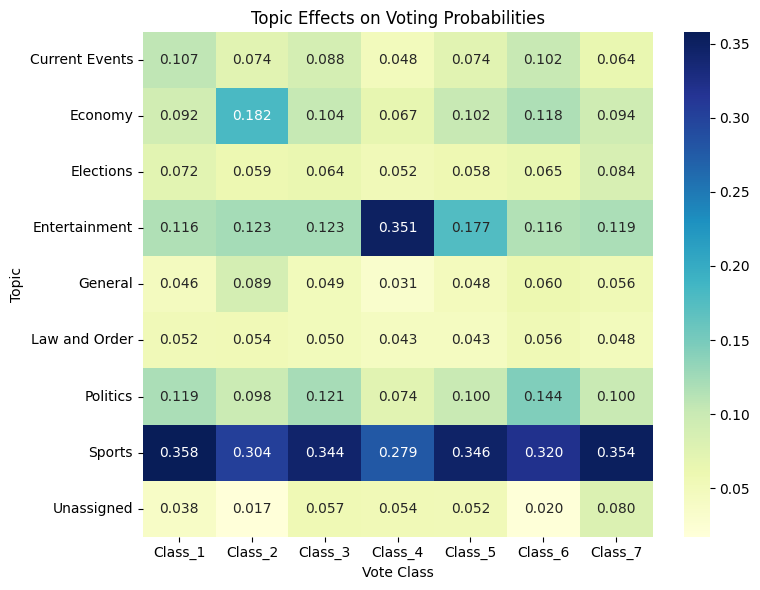

In [23]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Encode topics
label_encoder = LabelEncoder()
X = label_encoder.fit_transform(data['topic_label']).reshape(-1, 1)
y = data['secondvote']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

# Evaluation with zero_division parameter
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 3x3 Confusion Matrix
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(7),
            yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Previous code remains the same until after the confusion matrix...

# Topic effects analysis (corrected)
log_probs = nb_model.feature_log_prob_  # Shape: [n_features][n_classes][n_categories]
topic_effects = np.exp(log_probs[0])    # Get first (only) feature's probabilities

# Create DataFrame
topic_effects_df = pd.DataFrame(
    topic_effects.T,
    columns=[f"Class_{i}" for i in nb_model.classes_],
    index=label_encoder.classes_
)

print("\nTopic Effects on Voting:")
print(topic_effects_df)

# Visualization
plt.figure(figsize=(8,6))
sns.heatmap(topic_effects_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Topic Effects on Voting Probabilities')
plt.ylabel('Topic')
plt.xlabel('Vote Class')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11804
           1       0.46      0.33      0.39     37460
           2       0.48      0.74      0.59     41307

    accuracy                           0.48     90571
   macro avg       0.31      0.36      0.32     90571
weighted avg       0.41      0.48      0.43     90571



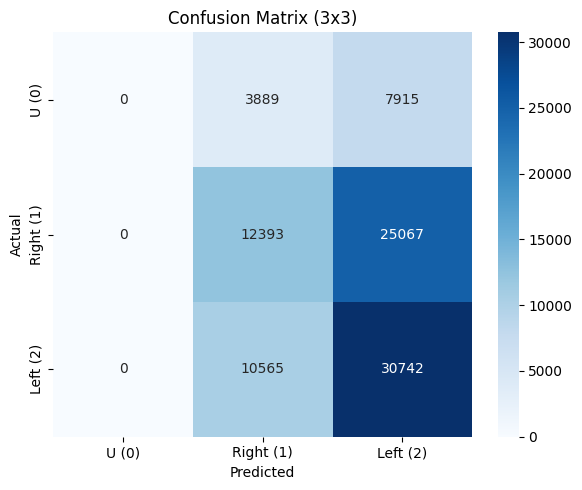


Topic Effects on Voting:
                 Class_0   Class_1   Class_2
Current Events  0.064942  0.100127  0.070354
Economy         0.093188  0.103925  0.141822
Elections       0.083109  0.066887  0.058002
Entertainment   0.119042  0.117678  0.171386
General         0.055583  0.051739  0.068345
Law and Order   0.049929  0.053160  0.049427
Politics        0.100536  0.127215  0.095040
Sports          0.352044  0.341938  0.312567
Unassigned      0.081627  0.037331  0.033056


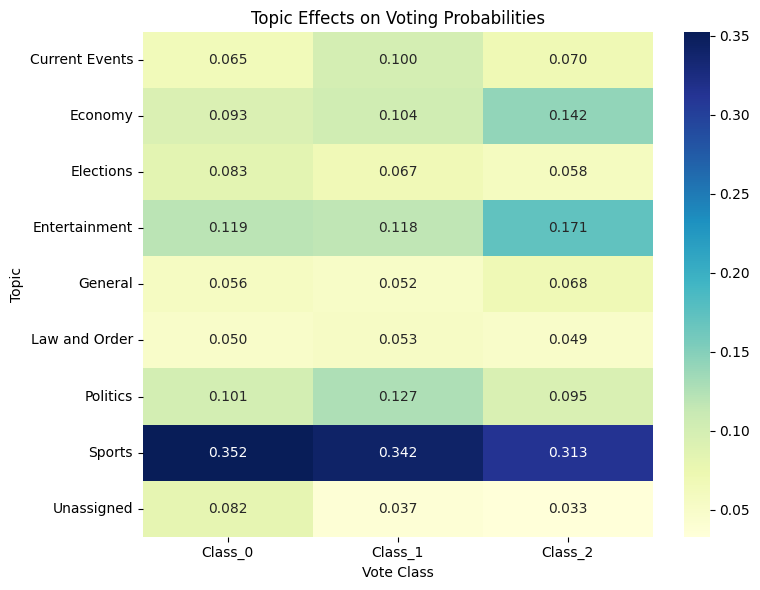

In [24]:

# Load and prepare data
data = pd.read_csv('Processed_Data/80_TopicLDA_Long.csv')
data['left_right'] = data['left_right'].map({0:0, 1:1, -1:2})  # Map to 0,1,2

# Encode topics
label_encoder = LabelEncoder()
X = label_encoder.fit_transform(data['topic_label']).reshape(-1, 1)
y = data['left_right']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

# Evaluation with zero_division parameter
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 3x3 Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['U (0)', 'Right (1)', 'Left (2)'],
            yticklabels=['U (0)', 'Right (1)', 'Left (2)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (3x3)')
plt.tight_layout()
plt.show()

# Previous code remains the same until after the confusion matrix...

# Topic effects analysis (corrected)
log_probs = nb_model.feature_log_prob_  # Shape: [n_features][n_classes][n_categories]
topic_effects = np.exp(log_probs[0])    # Get first (only) feature's probabilities

# Create DataFrame
topic_effects_df = pd.DataFrame(
    topic_effects.T,
    columns=[f"Class_{i}" for i in nb_model.classes_],
    index=label_encoder.classes_
)

print("\nTopic Effects on Voting:")
print(topic_effects_df)

# Visualization
plt.figure(figsize=(8,6))
sns.heatmap(topic_effects_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Topic Effects on Voting Probabilities')
plt.ylabel('Topic')
plt.xlabel('Vote Class')
plt.tight_layout()
plt.show()